# Sequencing quality stats

Notes on the quality of sequencing.

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Preparation

In [4]:
cluster_duplication = pd.read_table('fastdup.txt')

/ypool/applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [5]:
cluster_duplication['Kit'] = pd.Categorical(
    cluster_duplication.FILE.str.split("_").str.get(0).str.split("-").str.get(1)
)
cluster_duplication['Conc'] = pd.Categorical(
    cluster_duplication.FILE.str.split("_").str.get(0).str.split("-").str.get(2)
)
cluster_duplication['Replicate'] = cluster_duplication.FILE.str.split("_").str.get(0).str.split("-").str.get(3)
cluster_duplication['Sample'] = cluster_duplication.FILE.str.split("_").str.get(0)
cluster_duplication['Lane'] = pd.to_numeric(
    cluster_duplication.FILE.str.split("_").str.get(2).str.replace("L00", "")
)
cluster_duplication.head()

,FILE,NUM_READS,READS_WITH_DUP,DUP_RATIO,Kit,Conc,Replicate,Sample,Lane
0,10-Kapa-100ng-2_S10_L005_R1_001,25801617,1401641,0.054324,Kapa,100ng,2,10-Kapa-100ng-2,5
1,10-Kapa-100ng-2_S10_L006_R1_001,25207432,1373021,0.054469,Kapa,100ng,2,10-Kapa-100ng-2,6
2,10-Kapa-100ng-2_S10_L007_R1_001,24466845,1262147,0.051586,Kapa,100ng,2,10-Kapa-100ng-2,7
3,10-Kapa-100ng-2_S10_L008_R1_001,24319484,1294397,0.053225,Kapa,100ng,2,10-Kapa-100ng-2,8
4,11-Kapa-100ng-3_S11_L005_R1_001,28058818,1513737,0.053949,Kapa,100ng,3,11-Kapa-100ng-3,5


## Duplication (cluster duplicates) and PF

Numbers on duplication are based on suprDUPr duplicate statistics. PCR-duplicates not included, only duplicates located nearby on the flow cell.

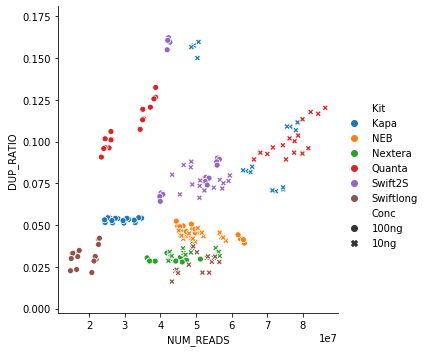

In [6]:
sns.relplot(data=cluster_duplication, x="NUM_READS", y="DUP_RATIO", hue="Kit", style="Conc")

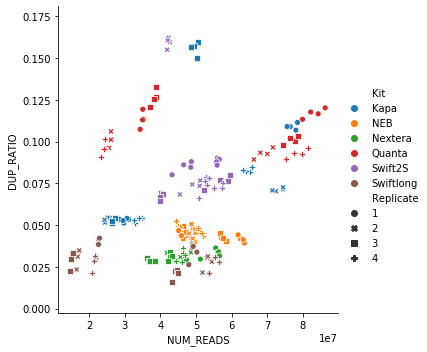

In [7]:
sns.relplot(data=cluster_duplication, x="NUM_READS", y="DUP_RATIO", hue="Kit", style="Replicate")

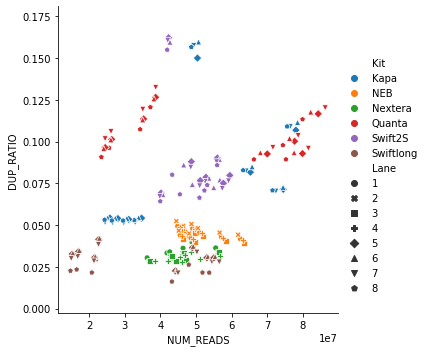

In [8]:
sns.relplot(data=cluster_duplication, x="NUM_READS", y="DUP_RATIO", hue="Kit", style="Lane")

Text(0, 0.5, 'Number of files')

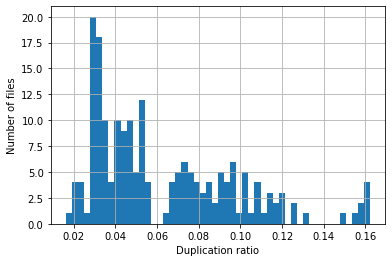

In [9]:
ax = cluster_duplication.DUP_RATIO.hist(bins=50)
ax.set_xlabel("Duplication ratio")
ax.set_ylabel("Number of files")

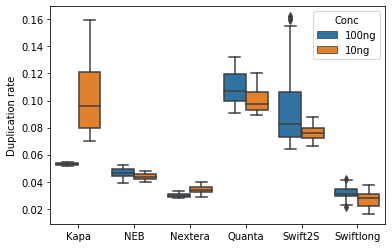

In [10]:
sns.boxplot(data=cluster_duplication, x='Kit', y='DUP_RATIO', hue='Conc')
plt.xlabel("")
plt.ylabel("Duplication rate")
plt.savefig("../plots/seq_suprdupr_examp_duplicates.pdf")

## Non-duplicate reads

In [11]:
cluster_duplication['Unique'] = (cluster_duplication.NUM_READS - cluster_duplication.READS_WITH_DUP)

Text(0, 0.5, 'Number of files')

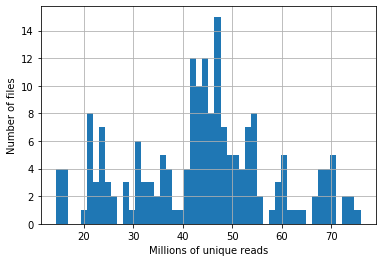

In [12]:
ax = (cluster_duplication.Unique / 1e6).hist(bins=50)
ax.set_xlabel("Millions of unique reads")
ax.set_ylabel("Number of files")

## Quality scores

Get the quality scores from a text file. The Q30 metrics and other metadata are collected from the reports produced by the demultiplexing tool (bcl2fatq).

These metrics were copied manually from the HTML-based report into a spreadsheet, then exported as a CSV file.

In [13]:
demux_reports = pd.read_csv("demux-report.csv", sep=";")

In [14]:
data = cluster_duplication.merge(demux_reports, on=["Sample", "Lane"])
data['SampleName'] = data.Sample.str.replace("^\d+-", "")
data.head()

data["Kit"] = pd.Categorical(data.Kit)

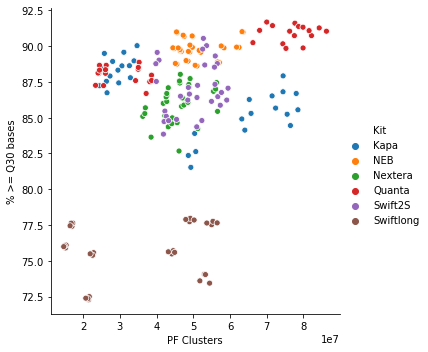

In [15]:
sns.relplot(data=data, x='PF Clusters', y='% >= Q30 bases', hue='Kit')

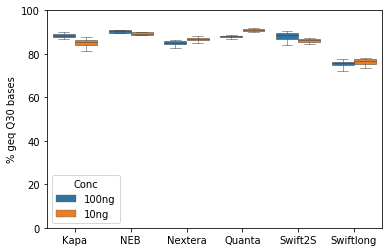

In [16]:
sns.boxplot(data=data, x='Kit', y='% >= Q30 bases', hue="Conc", linewidth=0.5)
plt.ylim(0, 100)
plt.xlabel("")
plt.ylabel(r"% geq Q30 bases")
plt.savefig("../plots/seq_q30_bases.pdf")

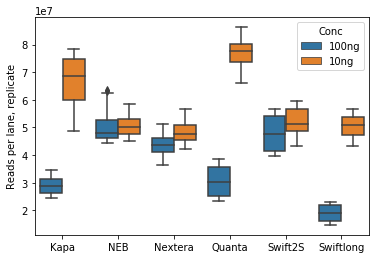

In [17]:
sns.boxplot(data=data, x='Kit', y='NUM_READS', hue="Conc")
plt.ylabel("Reads per lane, replicate")
plt.xlabel("")
plt.savefig("../plots/seq_reads_per_lane_and_sample.pdf")

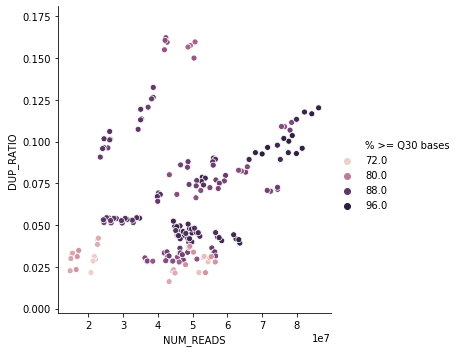

In [18]:
sns.relplot(data=data, x="NUM_READS", y="DUP_RATIO", hue="% >= Q30 bases")

## Only 100 ng datasets

In [19]:
hicon = data.loc[data['Conc'] == '100ng']
print(len(hicon))

96


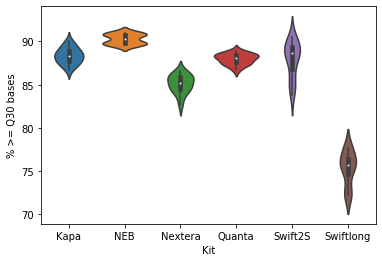

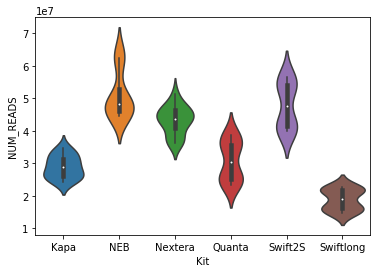

In [20]:
sns.violinplot(data=hicon, x='Kit', y='% >= Q30 bases')
plt.show()
sns.violinplot(data=hicon, x='Kit', y='NUM_READS')

## Unique, high quality reads

In [21]:
# Unique, high quality reads -- To be used later, but has to be defined in data
data['UQR'] = (data['% >= Q30 bases'] * data['Unique']) / 100.0
data['KitConcGroup'] = data['Kit'].str.cat(data['Conc'])
hicon = data.loc[data['Conc'] == '100ng']

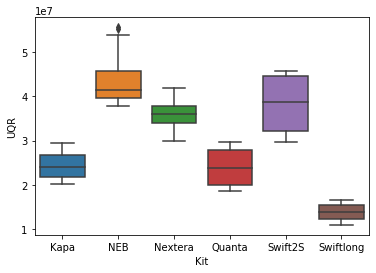

In [22]:
sns.boxplot(data=hicon, x='Kit', y='UQR')

In [23]:
hicon.dtypes

FILE                        object
NUM_READS                    int64
READS_WITH_DUP               int64
DUP_RATIO                  float64
Kit                       category
Conc                      category
Replicate                   object
Sample                      object
Lane                         int64
Unique                       int64
Run                         object
Project                     object
Barcode sequence            object
PF Clusters                  int64
% of the lane              float64
% Perfect barcode          float64
% One mismatch barcode     float64
Yield (Mbases)               int64
% PF Clusters              float64
% >= Q30 bases             float64
Mean Quality Score         float64
SampleName                  object
UQR                        float64
KitConcGroup                object
dtype: object

## Downsampling based on number of PF reads per kit

Number of unique reads after normalisation based on # PF reads. This is not quite correct, as the normalisation will make some reads no longer duplicates.

In [24]:
merged_lane_data = data.groupby(['Kit', 'Conc', 'Replicate'], as_index=False).sum().reindex()
merged_lane_data['SampleName'] = merged_lane_data.Kit.str.cat(
                    [merged_lane_data.Conc,
                    merged_lane_data.Replicate],
                    sep="-")

In [25]:
merged_lane_data.tail()

,Kit,Conc,Replicate,NUM_READS,READS_WITH_DUP,DUP_RATIO,Lane,Unique,PF Clusters,% of the lane,% Perfect barcode,% One mismatch barcode,Yield (Mbases),% PF Clusters,% >= Q30 bases,Mean Quality Score,UQR,SampleName
43,Swiftlong,100ng,4,85282020,2394455,0.112052,26,82887565,85282020,29.38,381.39,18.61,25755,400.0,289.53,131.81,5.999628e+07,Swiftlong-100ng-4
44,Swiftlong,10ng,1,196401834,6590677,0.134056,26,189811157,196401834,67.63,378.27,21.73,59314,400.0,311.44,137.57,1.477869e+08,Swiftlong-10ng-1
45,Swiftlong,10ng,2,212622041,5936052,0.111505,26,206685989,212622041,73.22,383.66,16.34,64212,400.0,295.14,133.28,1.525000e+08,Swiftlong-10ng-2
46,Swiftlong,10ng,3,176873410,3700255,0.083553,26,173173155,176873410,60.91,382.12,17.88,53415,400.0,302.41,135.13,1.309233e+08,Swiftlong-10ng-3
47,Swiftlong,10ng,4,220583499,6140240,0.111171,26,214443259,220583499,75.96,382.39,17.61,66616,400.0,310.57,137.36,1.664996e+08,Swiftlong-10ng-4


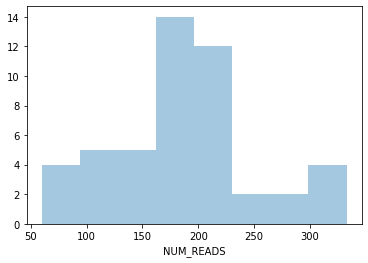

In [26]:
sns.distplot(merged_lane_data.NUM_READS / 1e6, kde=False)

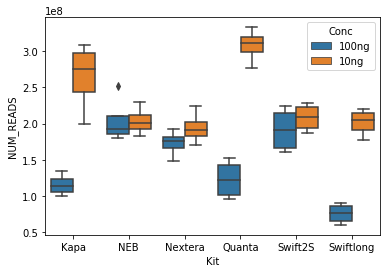

In [27]:
sns.boxplot(data=merged_lane_data, x='Kit', y='NUM_READS', hue='Conc')

In [28]:
merged_lane_data.NUM_READS.min()

60300078

In [29]:
merged_lane_data['ReadFactor'] = 90e6 / merged_lane_data.NUM_READS
merged_lane_data['ReadFactorCap'] = np.minimum(90e6 / merged_lane_data.NUM_READS, 1.0)

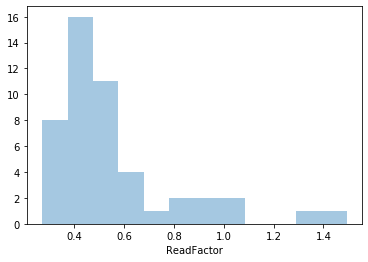

In [30]:
sns.distplot(merged_lane_data.ReadFactor, kde=False)

Write table to outfile

In [31]:
merged_lane_data.to_csv('../downsample_factors.csv', index=False, columns=['SampleName', 'ReadFactorCap'])

In [32]:
merged_lane_data.loc[merged_lane_data.Conc == "100ng"].groupby('Kit')[['NUM_READS']].mean()

,NUM_READS
Kit,
Kapa,1.157762e+08
NEB,2.041756e+08
Nextera,1.730642e+08
Quanta,1.232122e+08
Swift2S,1.914815e+08
Swiftlong,7.576854e+07


Validation of read counting logic in samtools: the following command counts the number of reads in the bam file:

    $ samtools view -c -F 0x900 20_piccard/Swift2S-10ng-4.bam
    441977732


In [33]:
print(merged_lane_data[merged_lane_data.SampleName == 'Swift2S-10ng-4'].NUM_READS * 2)

39    441977732
Name: NUM_READS, dtype: int64


# Output this data to a table

In [34]:
data.head(n=1)

,FILE,NUM_READS,READS_WITH_DUP,DUP_RATIO,Kit,Conc,Replicate,Sample,Lane,Unique,...,% of the lane,% Perfect barcode,% One mismatch barcode,Yield (Mbases),% PF Clusters,% >= Q30 bases,Mean Quality Score,SampleName,UQR,KitConcGroup
0,10-Kapa-100ng-2_S10_L005_R1_001,25801617,1401641,0.054324,Kapa,100ng,2,10-Kapa-100ng-2,5,24399976,...,6.39,96.41,3.59,7792,100.0,89.49,37.56,Kapa-100ng-2,2.183554e+07,Kapa100ng


In [39]:
data[['Kit', 'Conc', 'Replicate', 'Lane', 'NUM_READS', '% >= Q30 bases', 'FILE']].to_csv("sequencing-metrics.csv", index=False)